# Conditional Wassersteing GAN with gradient penalty

In this example a WGAN is built and trained on the MNIST dataset.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

%matplotlib inline

Enable memory growth for GPU, it is needed on some systems for convolution to work.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Load the images dataset and normalize it to [-1..1] range We will use only its train part, so skip the testing.

In [3]:
(x_train, y_train), (_ , _) = tf.keras.datasets.mnist.load_data()
datax = (x_train/127.5)-1.0
datax = datax.astype("float32")
labels = tf.keras.utils.to_categorical(y_train)

Define the dimensionality of inputs, dimensionality of the hidden space and leaking coefficient

In [4]:
inp_dim = datax.shape[1:3]
n_classes = labels.shape[1]
hidden_dim = 2
a = 0.1
k = 0.1

Firstly, define discriminator model. Note the linear activation in the last layer. No batch normalization is used here, since it is not compatible with gradient penalty. Authors suggested usage of layer normalization here, but it is quite computationally-heavy.

In [5]:
data_input = Input(shape=(inp_dim[0],inp_dim[1],1))

labels_input = Input(shape=(n_classes,))

x = Conv2D(16, (5,5), padding="same")(data_input)
x = LeakyReLU(a)(x)
x = MaxPool2D((2,2))(x)

x = Conv2D(32, (3,3), padding="same")(x)
x = LeakyReLU(a)(x)
x = MaxPool2D((2,2))(x)

x = Flatten()(x)
x = Dropout(k)(x)

x = Concatenate()([x, labels_input])

x = Dropout(k)(x)
x = Dense(100, activation="linear")(x)
x = LeakyReLU(a)(x)

x = Dropout(k)(x)
x = Dense(50, activation="linear")(x)
x = LeakyReLU(a)(x)

discrim_out = Dense(1, activation="linear")(x)

discriminator = Model([data_input, labels_input], discrim_out)

Define generator model. Here, instead of the upsampling layers, a transposed convolution is used, which is roughly equivalent to the normal convolution, followed by upsampling.

In [6]:
hidden_input = Input(shape=(hidden_dim,))

x = Concatenate()([hidden_input, labels_input])

x = Dense(32*inp_dim[0]//4*inp_dim[1]//4, activation="linear")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)

x = Reshape((inp_dim[0]//4, inp_dim[1]//4, 32))(x)

x = Conv2D(32, (3,3), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)

x = Conv2DTranspose(16, (3,3), strides=(2,2), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)

x = Conv2DTranspose(8, (5,5), strides=(2,2), padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(a)(x)

gen_out = Conv2D(1, (3,3), padding="same", activation="tanh")(x)

generator = Model([hidden_input, labels_input], gen_out)

Define a function that will sample from the $\hat{X}_g=\epsilon X+(1-\epsilon)X_{g},\,\epsilon\sim\mathcal{U}(0,1)$ on the tensor level.

In [7]:
@tf.function
def random_lincomb(x_real, x_gen):
    batch_size = tf.shape(x_real)[0]
    epsilon = tf.random.uniform((batch_size,1,1,1))
    return epsilon*x_real+(1.0-epsilon)*x_gen

This function generates estimates $$\mathbb{E}_{\hat{{X}}\sim p(\hat{X}_{g})}\big[\max(||\nabla_{\hat{{X}}}D(\hat{{X}})||-1, 0)^{2}\big] by sampling from $\hat{X}_g$, getting gradients at that points and averaging them.  
Scope GradientTape allow differentiation of arbitrary operations inside the scope.   
We need to pass training=True to all operations with model which will be then used to update the weights. This flag is needed for layers, which behave differently in training and testing regimes (such as dropout)

In [8]:
@tf.function
def grad_penalty(real_data, gen_data, labels):
    batch_size = tf.shape(real_data)[0]
    # combine them with real samples and estimate gradients
    lincomb = random_lincomb(real_data, gen_data)
    with tf.GradientTape() as t:
        t.watch(lincomb)
        d_out = discriminator([lincomb, labels], training=True)
        grads = t.gradient(d_out, lincomb)
    # calculate L2 norm (except for batch dimension) and penalty
    l2_grads = tf.math.sqrt(tf.math.reduce_sum(grads**2, axis=[1,2,3]))
    penalty = tf.math.reduce_mean((tf.math.maximum(l2_grads-1.0, 0.0))**2)
    return penalty

Discriminator tries to find the value of Wasserstein loss by optimizing the objective $$\max_{\theta_{1}}\mathbb{E}_{X\sim\mathbb{{X}}}[D(X,\theta_{1})]-\mathbb{E}_{Z\sim p(Z)}[D(G(Z),\theta_{1})]$$
We will need to change the signs to convert it to the minimization problem

In [9]:
@tf.function
def discriminator_loss(real_data, gen_data):
    # real data: D(X), gen_data: D(G(Z))
    loss = -tf.math.reduce_mean(real_data) + tf.math.reduce_mean(gen_data)
    return loss

Now the generator losses 

$$ \begin{align}
\min_{\theta_{2}}\mathbb{E}_{X\sim\mathbb{{X}}}[D(X)]-\mathbb{E}_{Z\sim p(Z)}[D(G(Z,\theta_{2}))] &= \min_{\theta_2} -\mathbb{E}_{Z\sim p(Z)}[D(G(Z,\theta_{2}))]
\end{align}$$

In [10]:
def generator_loss(pred):
    # pred: D(G(Z))
    return -tf.math.reduce_mean(pred)

Now save the trainable variables (parameters) of both $D$ and $G$ to the variables. This is needed because we will frequently update them, while direct call referencing as discriminator.trainable_variables is slow, since TF is looking for all variables on the access to it.  
Instantiate the optimizers used (according to the original article) and penalty coefficient $\lambda$.

In [11]:
discr_trainable_vars = discriminator.trainable_variables
gen_trainable_vars = generator.trainable_variables

discr_optimizer = Adam(lr=1e-4, beta_1=0.0, beta_2=0.9)
gen_optimizer =  Adam(lr=1e-4, beta_1=0.0, beta_2=0.9)

lmbd = 10.0

The structure of the network is now very different from the classical tf.keras models, so we will not use methods like .fit but will directly update weights of the models by calling optimizer.apply_gradients.

In [12]:
@tf.function
def train_discriminator(data_batch, labels_batch):
    batch_size = tf.shape(data_batch)[0]
    # sample from p(Z) and generate batch of data
    noise = tf.random.normal((batch_size, hidden_dim))
    generated = generator([noise, labels_batch], training=True)
    
    with tf.GradientTape() as t:
        # get both predictions from discriminator, i.e. D(X) and D(G(Z))
        discr_pred_true = discriminator([data_batch, labels_batch], training=True)
        discr_pred_gen = discriminator([generated, labels_batch], training=True)
        # calculate the loss, i.e. approximation of Wass. metric
        wass_loss = discriminator_loss(discr_pred_true, discr_pred_gen)
        # get the gradient penalty and combine them to form total loss
        penalty = grad_penalty(data_batch, generated, labels_batch)
        total_loss = wass_loss+lmbd*penalty
        # calculate gradients of total loss w.r.t. discriminator parameters
        grads = t.gradient(total_loss, discr_trainable_vars)
    # update the weights, according to the calculated gradients
    res_loss = discr_optimizer.apply_gradients(zip(grads, discr_trainable_vars))
    return wass_loss, penalty
    
    

Similarly, update the generator weights.

In [13]:
@tf.function
def train_generator(labels_batch):
    # sample from p(Z)
    batch_size = tf.shape(labels_batch)[0]
    noise = tf.random.normal((batch_size, hidden_dim))
    # generate data, predict D(G(Z))
    with tf.GradientTape() as t:
        generated = generator([noise, labels_batch], training=True)
        discr_predicted = discriminator([generated, labels_batch], training=True)
        wass_loss = generator_loss(discr_predicted)
        # get the gradients of W w.r.t. generator weights
        grads = t.gradient(wass_loss, gen_trainable_vars)
    # update generator weights
    discr_optimizer.apply_gradients(zip(grads, gen_trainable_vars))
    return wass_loss
        

A tiny helper function to shuffle the dataset after end of epoch.

In [14]:
def shuffle(X, Y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    return X[indices], Y[indices]

Define the training parameters, including number of repeatition during training of discriminator (5, according to the original article), batch size, number of epochs, number of extra steps for discriminator training and visualization frequency.

In [15]:
n_discr = 5
batch_size = 128
n_epochs = 250
discr_extra_steps = 20
summary_every_batches = 100
plot_every_epochs = 10

Define a helper function to visualize the images. It investigates hidden space by sampling points on a $[-1,1]\times[-1,1]$ grid and generated images, with this points as Z.

In [16]:
def grid_images(generator, im_idx, grid = (10, 10)):
    x = np.linspace(-1, 1, grid[0])
    y = np.linspace(-1, 1, grid[1])
    XX,YY = np.meshgrid(x, y)
    noisegrid = np.vstack([XX.flatten(), YY.flatten()]).T
    labs = np.repeat(tf.keras.utils.to_categorical([im_idx], 10), grid[0]*grid[1], axis=0)
    generated = generator([noisegrid, labs])
    plt.figure(figsize=(5,5))
    idx=1
    for im in generated:
        plt.subplot(grid[0], grid[1], idx)
        plt.imshow(np.squeeze(im), cmap="gray")
        idx+=1
        plt.axis("off")
    plt.tight_layout(0)
    

Finally, train the network as follows  
1) Sample a batch of data from dataset  
2) Train discriminator with this sample for n_discr times.  
3) Update weights of generator to reduce the Wasserstain distance, approximated by discriminator  
4) Each summary_every_batches iteration print the summary. Before printing, train discriminator for a few more epochs to ensure convergence to the Wasserstein distance  
  
Note that the approximated Wasserstein loss is converging to lower values as model trains.

Epoch 0
W estimate: 1.600, grad penlaty: 0.000, gen correction 0.088
W estimate: 19.748, grad penlaty: 0.371, gen correction 3.550
W estimate: 21.233, grad penlaty: 0.434, gen correction 8.891
W estimate: 19.794, grad penlaty: 0.363, gen correction 12.279
W estimate: 17.384, grad penlaty: 0.313, gen correction 13.880

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



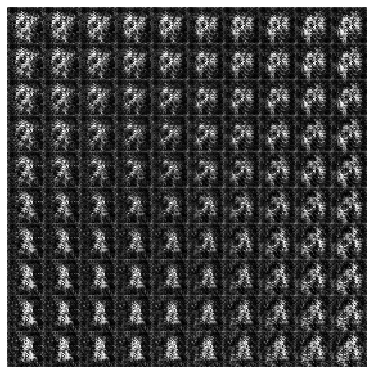

Epoch 1
W estimate: 15.764, grad penlaty: 0.282, gen correction 14.692
W estimate: 12.815, grad penlaty: 0.227, gen correction 15.832
W estimate: 11.329, grad penlaty: 0.169, gen correction 16.611
W estimate: 10.101, grad penlaty: 0.135, gen correction 16.643
W estimate: 8.841, grad penlaty: 0.123, gen correction 16.930
Epoch 2
W estimate: 7.892, grad penlaty: 0.099, gen correction 16.921
W estimate: 6.965, grad penlaty: 0.086, gen correction 16.340
W estimate: 6.925, grad penlaty: 0.074, gen correction 15.955
W estimate: 6.454, grad penlaty: 0.064, gen correction 15.922
W estimate: 5.756, grad penlaty: 0.059, gen correction 15.153
Epoch 3
W estimate: 4.765, grad penlaty: 0.041, gen correction 15.687
W estimate: 4.803, grad penlaty: 0.035, gen correction 14.320
W estimate: 4.242, grad penlaty: 0.040, gen correction 13.913
W estimate: 4.189, grad penlaty: 0.039, gen correction 13.545
W estimate: 4.209, grad penlaty: 0.032, gen correction 12.390
Epoch 4
W estimate: 3.511, grad penlaty: 0

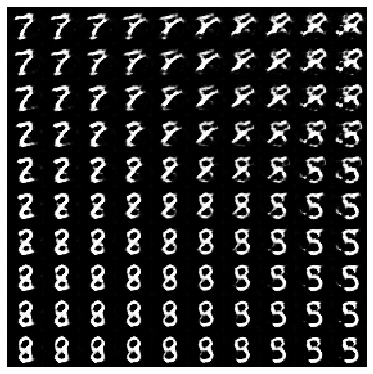

Epoch 11
W estimate: 3.414, grad penlaty: 0.025, gen correction 3.316
W estimate: 3.510, grad penlaty: 0.024, gen correction 3.868
W estimate: 3.812, grad penlaty: 0.027, gen correction 3.498
W estimate: 3.757, grad penlaty: 0.032, gen correction 3.315
W estimate: 3.719, grad penlaty: 0.034, gen correction 3.252
Epoch 12
W estimate: 3.084, grad penlaty: 0.026, gen correction 3.586
W estimate: 3.530, grad penlaty: 0.026, gen correction 3.315
W estimate: 4.073, grad penlaty: 0.031, gen correction 3.674
W estimate: 3.807, grad penlaty: 0.030, gen correction 2.988
W estimate: 4.674, grad penlaty: 0.045, gen correction 2.792
Epoch 13
W estimate: 3.727, grad penlaty: 0.036, gen correction 3.188
W estimate: 3.739, grad penlaty: 0.029, gen correction 3.381
W estimate: 3.656, grad penlaty: 0.024, gen correction 3.522
W estimate: 3.342, grad penlaty: 0.027, gen correction 3.196
W estimate: 3.601, grad penlaty: 0.029, gen correction 2.375
Epoch 14
W estimate: 3.455, grad penlaty: 0.024, gen corre

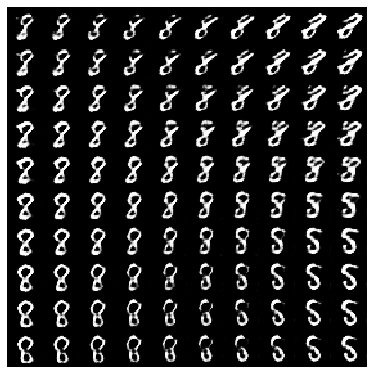

Epoch 21
W estimate: 2.044, grad penlaty: 0.027, gen correction 1.816
W estimate: 1.751, grad penlaty: 0.017, gen correction -0.080
W estimate: 1.875, grad penlaty: 0.016, gen correction 1.370
W estimate: 1.835, grad penlaty: 0.013, gen correction 1.015
W estimate: 2.033, grad penlaty: 0.018, gen correction 1.111
Epoch 22
W estimate: 2.207, grad penlaty: 0.023, gen correction 0.033
W estimate: 2.280, grad penlaty: 0.019, gen correction -0.515
W estimate: 2.387, grad penlaty: 0.015, gen correction 1.353
W estimate: 1.263, grad penlaty: 0.010, gen correction 0.505
W estimate: 1.117, grad penlaty: 0.019, gen correction 0.630
Epoch 23
W estimate: 2.113, grad penlaty: 0.018, gen correction 0.584
W estimate: 1.696, grad penlaty: 0.011, gen correction 0.382
W estimate: 2.677, grad penlaty: 0.013, gen correction 0.280
W estimate: 2.398, grad penlaty: 0.021, gen correction 0.088
W estimate: 2.350, grad penlaty: 0.018, gen correction -0.433
Epoch 24
W estimate: 2.373, grad penlaty: 0.044, gen co

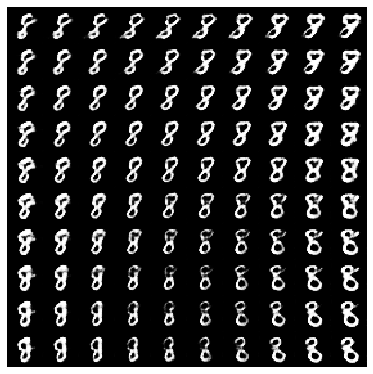

Epoch 31
W estimate: 1.712, grad penlaty: 0.015, gen correction -0.580
W estimate: 1.773, grad penlaty: 0.013, gen correction -0.066
W estimate: 2.483, grad penlaty: 0.016, gen correction -1.006
W estimate: 1.551, grad penlaty: 0.015, gen correction 0.873
W estimate: 1.748, grad penlaty: 0.014, gen correction -0.824
Epoch 32
W estimate: 1.643, grad penlaty: 0.008, gen correction -0.136
W estimate: 2.312, grad penlaty: 0.014, gen correction -1.303
W estimate: 1.891, grad penlaty: 0.014, gen correction 0.608
W estimate: 1.555, grad penlaty: 0.014, gen correction 0.034
W estimate: 2.014, grad penlaty: 0.015, gen correction -0.328
Epoch 33
W estimate: 1.954, grad penlaty: 0.014, gen correction 0.158
W estimate: 2.209, grad penlaty: 0.015, gen correction 0.491
W estimate: 1.725, grad penlaty: 0.015, gen correction 0.536
W estimate: 2.123, grad penlaty: 0.014, gen correction -0.355
W estimate: 1.962, grad penlaty: 0.011, gen correction 1.078
Epoch 34
W estimate: 2.054, grad penlaty: 0.024, g

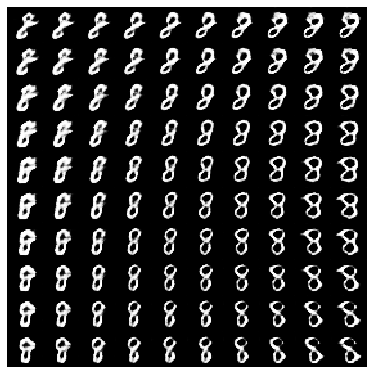

Epoch 41
W estimate: 2.496, grad penlaty: 0.014, gen correction -1.531
W estimate: 1.688, grad penlaty: 0.018, gen correction -0.528
W estimate: 1.453, grad penlaty: 0.017, gen correction 0.259
W estimate: 1.534, grad penlaty: 0.015, gen correction -0.342
W estimate: 1.483, grad penlaty: 0.015, gen correction -0.202
Epoch 42
W estimate: 2.080, grad penlaty: 0.010, gen correction -0.883
W estimate: 1.927, grad penlaty: 0.013, gen correction -0.731
W estimate: 1.334, grad penlaty: 0.009, gen correction -0.480
W estimate: 2.557, grad penlaty: 0.019, gen correction 0.193
W estimate: 2.689, grad penlaty: 0.021, gen correction 0.734
Epoch 43
W estimate: 2.488, grad penlaty: 0.012, gen correction -0.258
W estimate: 1.692, grad penlaty: 0.014, gen correction 0.109
W estimate: 1.799, grad penlaty: 0.014, gen correction 0.239
W estimate: 1.820, grad penlaty: 0.016, gen correction 1.334
W estimate: 1.849, grad penlaty: 0.012, gen correction 0.603
Epoch 44
W estimate: 2.058, grad penlaty: 0.019, g

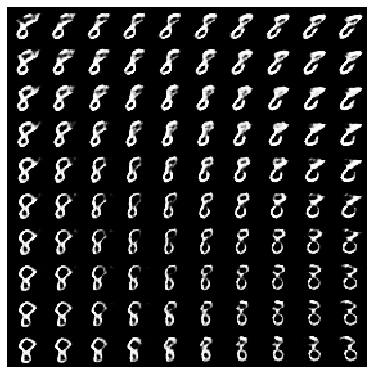

Epoch 51
W estimate: 1.846, grad penlaty: 0.011, gen correction 0.379
W estimate: 1.562, grad penlaty: 0.016, gen correction 0.429
W estimate: 1.818, grad penlaty: 0.015, gen correction 1.366
W estimate: 2.815, grad penlaty: 0.022, gen correction 0.202
W estimate: 1.502, grad penlaty: 0.008, gen correction 0.286
Epoch 52
W estimate: 1.710, grad penlaty: 0.014, gen correction -0.409
W estimate: 1.659, grad penlaty: 0.014, gen correction 0.851
W estimate: 1.829, grad penlaty: 0.016, gen correction 2.096
W estimate: 1.837, grad penlaty: 0.013, gen correction -0.110
W estimate: 1.576, grad penlaty: 0.015, gen correction 0.857
Epoch 53
W estimate: 2.122, grad penlaty: 0.019, gen correction 0.534
W estimate: 1.524, grad penlaty: 0.014, gen correction -0.337
W estimate: 1.941, grad penlaty: 0.014, gen correction 0.719
W estimate: 1.730, grad penlaty: 0.020, gen correction -0.311
W estimate: 1.475, grad penlaty: 0.012, gen correction 0.172
Epoch 54
W estimate: 2.182, grad penlaty: 0.014, gen c

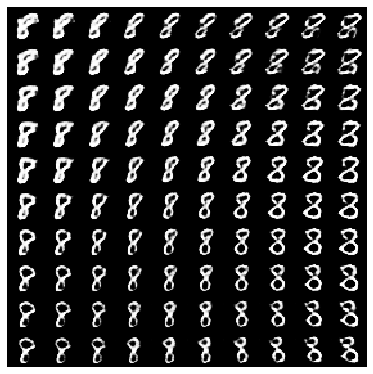

Epoch 61
W estimate: 1.620, grad penlaty: 0.013, gen correction 0.701
W estimate: 1.971, grad penlaty: 0.018, gen correction 0.253
W estimate: 1.972, grad penlaty: 0.016, gen correction 1.812
W estimate: 1.044, grad penlaty: 0.013, gen correction 0.315
W estimate: 1.673, grad penlaty: 0.012, gen correction 0.687
Epoch 62
W estimate: 2.316, grad penlaty: 0.013, gen correction 0.899
W estimate: 1.680, grad penlaty: 0.011, gen correction 0.292
W estimate: 1.489, grad penlaty: 0.012, gen correction 0.864
W estimate: 1.769, grad penlaty: 0.015, gen correction 0.932
W estimate: 1.603, grad penlaty: 0.021, gen correction 1.495
Epoch 63
W estimate: 1.848, grad penlaty: 0.017, gen correction 0.659
W estimate: 2.699, grad penlaty: 0.023, gen correction 0.741
W estimate: 2.476, grad penlaty: 0.017, gen correction 0.747
W estimate: 1.879, grad penlaty: 0.034, gen correction 0.904
W estimate: 1.351, grad penlaty: 0.013, gen correction 0.210
Epoch 64
W estimate: 1.532, grad penlaty: 0.014, gen corre

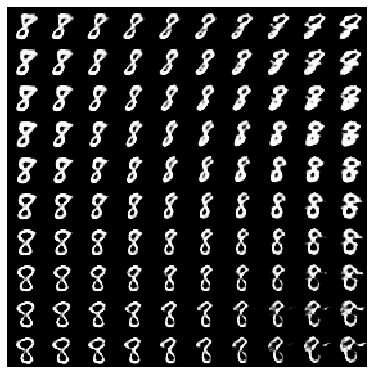

Epoch 71
W estimate: 2.339, grad penlaty: 0.024, gen correction -1.920
W estimate: 1.775, grad penlaty: 0.018, gen correction -1.115
W estimate: 1.725, grad penlaty: 0.016, gen correction -1.603
W estimate: 1.984, grad penlaty: 0.010, gen correction -0.508
W estimate: 1.927, grad penlaty: 0.014, gen correction -0.948
Epoch 72
W estimate: 1.657, grad penlaty: 0.017, gen correction 1.113
W estimate: 2.281, grad penlaty: 0.009, gen correction 0.704
W estimate: 1.717, grad penlaty: 0.012, gen correction 1.479
W estimate: 1.832, grad penlaty: 0.017, gen correction 1.765
W estimate: 2.089, grad penlaty: 0.009, gen correction 1.107
Epoch 73
W estimate: 1.725, grad penlaty: 0.013, gen correction 1.932
W estimate: 2.099, grad penlaty: 0.014, gen correction 0.143
W estimate: 2.055, grad penlaty: 0.024, gen correction 0.572
W estimate: 2.046, grad penlaty: 0.020, gen correction 0.662
W estimate: 1.895, grad penlaty: 0.015, gen correction 0.925
Epoch 74
W estimate: 1.677, grad penlaty: 0.021, gen 

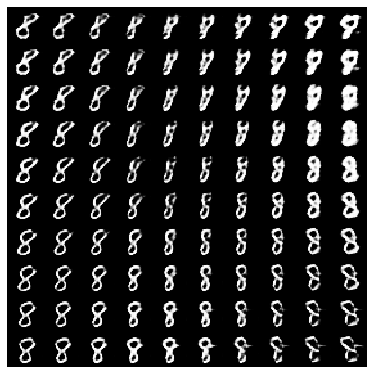

Epoch 81
W estimate: 1.070, grad penlaty: 0.011, gen correction -0.577
W estimate: 1.103, grad penlaty: 0.014, gen correction 0.496
W estimate: 1.878, grad penlaty: 0.013, gen correction -0.779
W estimate: 1.794, grad penlaty: 0.012, gen correction 0.135
W estimate: 2.138, grad penlaty: 0.013, gen correction -0.399
Epoch 82
W estimate: 1.274, grad penlaty: 0.012, gen correction -0.437
W estimate: 1.425, grad penlaty: 0.010, gen correction 1.316
W estimate: 1.193, grad penlaty: 0.011, gen correction -0.557
W estimate: 1.549, grad penlaty: 0.012, gen correction -0.579
W estimate: 1.300, grad penlaty: 0.009, gen correction -1.010
Epoch 83
W estimate: 2.118, grad penlaty: 0.012, gen correction 1.075
W estimate: 1.733, grad penlaty: 0.012, gen correction -0.518
W estimate: 1.537, grad penlaty: 0.011, gen correction -0.181
W estimate: 2.067, grad penlaty: 0.016, gen correction -0.530
W estimate: 1.655, grad penlaty: 0.014, gen correction -0.342
Epoch 84
W estimate: 1.377, grad penlaty: 0.012

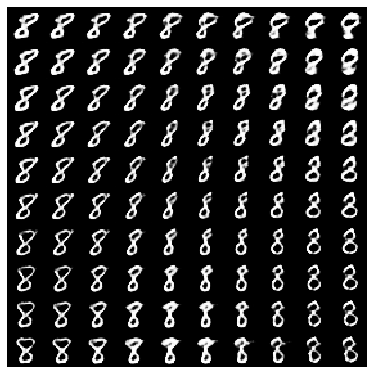

Epoch 91
W estimate: 1.840, grad penlaty: 0.015, gen correction -0.331
W estimate: 1.559, grad penlaty: 0.010, gen correction -0.571
W estimate: 1.726, grad penlaty: 0.018, gen correction -0.152
W estimate: 1.137, grad penlaty: 0.012, gen correction 0.264
W estimate: 1.950, grad penlaty: 0.011, gen correction 0.337
Epoch 92
W estimate: 1.109, grad penlaty: 0.014, gen correction -0.432
W estimate: 1.715, grad penlaty: 0.018, gen correction -0.422
W estimate: 2.155, grad penlaty: 0.028, gen correction -1.622
W estimate: 1.845, grad penlaty: 0.013, gen correction 0.097
W estimate: 1.571, grad penlaty: 0.008, gen correction -0.478
Epoch 93
W estimate: 1.650, grad penlaty: 0.012, gen correction -0.020
W estimate: 1.992, grad penlaty: 0.013, gen correction -1.973
W estimate: 1.580, grad penlaty: 0.017, gen correction -0.568
W estimate: 1.515, grad penlaty: 0.011, gen correction -0.643
W estimate: 2.120, grad penlaty: 0.013, gen correction -0.991
Epoch 94
W estimate: 1.519, grad penlaty: 0.01

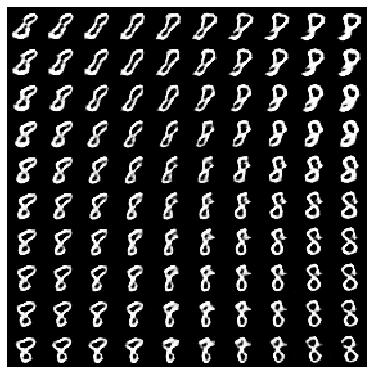

Epoch 101
W estimate: 1.601, grad penlaty: 0.012, gen correction -1.321
W estimate: 1.322, grad penlaty: 0.016, gen correction 0.052
W estimate: 1.639, grad penlaty: 0.013, gen correction -0.355
W estimate: 1.335, grad penlaty: 0.010, gen correction 0.281
W estimate: 1.330, grad penlaty: 0.011, gen correction 0.117
Epoch 102
W estimate: 2.007, grad penlaty: 0.010, gen correction 0.679
W estimate: 1.517, grad penlaty: 0.016, gen correction 1.162
W estimate: 1.069, grad penlaty: 0.011, gen correction 0.844
W estimate: 1.110, grad penlaty: 0.017, gen correction 1.254
W estimate: 1.905, grad penlaty: 0.016, gen correction 1.353
Epoch 103
W estimate: 1.102, grad penlaty: 0.011, gen correction 1.075
W estimate: 1.821, grad penlaty: 0.010, gen correction 0.577
W estimate: 1.702, grad penlaty: 0.012, gen correction 0.226
W estimate: 1.766, grad penlaty: 0.017, gen correction 0.778
W estimate: 1.471, grad penlaty: 0.009, gen correction 0.435
Epoch 104
W estimate: 1.637, grad penlaty: 0.015, gen

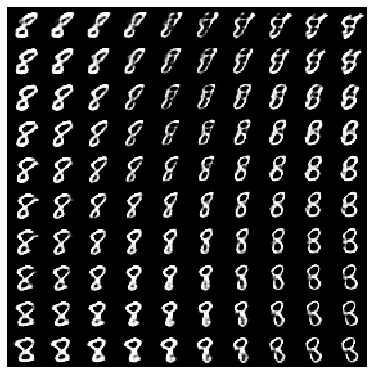

Epoch 111
W estimate: 1.344, grad penlaty: 0.014, gen correction 0.229
W estimate: 2.019, grad penlaty: 0.017, gen correction 0.834
W estimate: 1.930, grad penlaty: 0.016, gen correction 0.821
W estimate: 1.664, grad penlaty: 0.010, gen correction -0.846
W estimate: 1.111, grad penlaty: 0.007, gen correction -1.706
Epoch 112
W estimate: 1.156, grad penlaty: 0.011, gen correction -1.125
W estimate: 1.665, grad penlaty: 0.018, gen correction -0.849
W estimate: 1.215, grad penlaty: 0.012, gen correction -1.498
W estimate: 1.542, grad penlaty: 0.009, gen correction 0.732
W estimate: 1.120, grad penlaty: 0.012, gen correction 0.456
Epoch 113
W estimate: 1.752, grad penlaty: 0.014, gen correction -1.382
W estimate: 0.920, grad penlaty: 0.007, gen correction 0.029
W estimate: 1.439, grad penlaty: 0.011, gen correction -0.796
W estimate: 1.421, grad penlaty: 0.011, gen correction -1.008
W estimate: 2.028, grad penlaty: 0.015, gen correction -1.348
Epoch 114
W estimate: 1.230, grad penlaty: 0.0

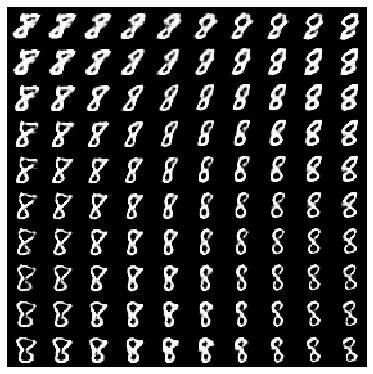

Epoch 121
W estimate: 2.052, grad penlaty: 0.006, gen correction -0.455
W estimate: 1.168, grad penlaty: 0.006, gen correction -0.597
W estimate: 1.936, grad penlaty: 0.016, gen correction 0.254
W estimate: 1.283, grad penlaty: 0.008, gen correction 0.383
W estimate: 1.527, grad penlaty: 0.012, gen correction -0.288
Epoch 122
W estimate: 1.449, grad penlaty: 0.011, gen correction -0.859
W estimate: 1.547, grad penlaty: 0.008, gen correction -0.501
W estimate: 1.837, grad penlaty: 0.008, gen correction 0.398
W estimate: 1.532, grad penlaty: 0.012, gen correction -0.279
W estimate: 1.662, grad penlaty: 0.014, gen correction -0.692
Epoch 123
W estimate: 1.684, grad penlaty: 0.013, gen correction -0.532
W estimate: 1.601, grad penlaty: 0.015, gen correction 1.115
W estimate: 2.228, grad penlaty: 0.013, gen correction 0.327
W estimate: 1.460, grad penlaty: 0.010, gen correction -0.361
W estimate: 1.395, grad penlaty: 0.012, gen correction -1.159
Epoch 124
W estimate: 1.907, grad penlaty: 0.

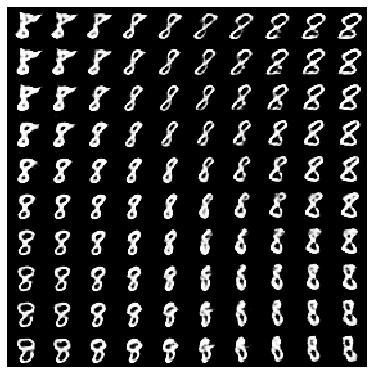

Epoch 131
W estimate: 1.748, grad penlaty: 0.006, gen correction 0.556
W estimate: 1.469, grad penlaty: 0.016, gen correction 0.207
W estimate: 1.473, grad penlaty: 0.012, gen correction -0.165
W estimate: 1.941, grad penlaty: 0.012, gen correction -0.369
W estimate: 1.618, grad penlaty: 0.008, gen correction 0.893
Epoch 132
W estimate: 2.105, grad penlaty: 0.012, gen correction -1.711
W estimate: 1.702, grad penlaty: 0.011, gen correction 0.116
W estimate: 1.929, grad penlaty: 0.013, gen correction -0.136
W estimate: 1.774, grad penlaty: 0.011, gen correction -0.133
W estimate: 1.480, grad penlaty: 0.015, gen correction -1.834
Epoch 133
W estimate: 1.316, grad penlaty: 0.011, gen correction -0.763
W estimate: 1.607, grad penlaty: 0.012, gen correction -0.500
W estimate: 1.705, grad penlaty: 0.011, gen correction 0.757
W estimate: 1.947, grad penlaty: 0.013, gen correction -0.352
W estimate: 1.778, grad penlaty: 0.013, gen correction 0.232
Epoch 134
W estimate: 1.740, grad penlaty: 0.0

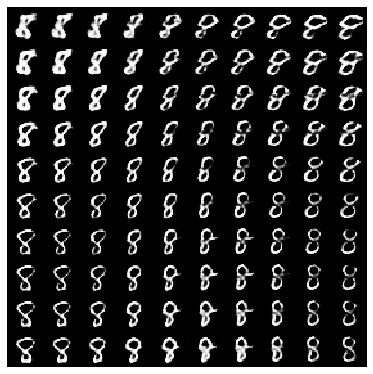

Epoch 141
W estimate: 1.513, grad penlaty: 0.012, gen correction -0.293
W estimate: 1.605, grad penlaty: 0.013, gen correction -1.177
W estimate: 2.006, grad penlaty: 0.007, gen correction -1.397
W estimate: 1.788, grad penlaty: 0.012, gen correction -1.561
W estimate: 1.135, grad penlaty: 0.008, gen correction -1.487
Epoch 142
W estimate: 1.361, grad penlaty: 0.013, gen correction -0.728
W estimate: 1.621, grad penlaty: 0.009, gen correction -1.387
W estimate: 1.948, grad penlaty: 0.017, gen correction -1.202
W estimate: 1.843, grad penlaty: 0.016, gen correction -1.481
W estimate: 2.343, grad penlaty: 0.011, gen correction -0.491
Epoch 143
W estimate: 1.541, grad penlaty: 0.017, gen correction -0.813
W estimate: 2.074, grad penlaty: 0.008, gen correction -0.404
W estimate: 2.134, grad penlaty: 0.015, gen correction 0.630
W estimate: 1.041, grad penlaty: 0.008, gen correction 0.312
W estimate: 1.885, grad penlaty: 0.010, gen correction -1.694
Epoch 144
W estimate: 1.556, grad penlaty:

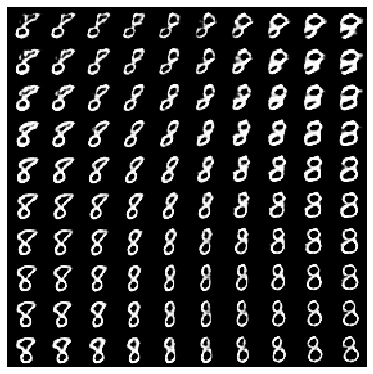

Epoch 151
W estimate: 1.429, grad penlaty: 0.011, gen correction -0.728
W estimate: 1.010, grad penlaty: 0.007, gen correction 0.076
W estimate: 1.489, grad penlaty: 0.018, gen correction -0.072
W estimate: 1.778, grad penlaty: 0.006, gen correction 0.146
W estimate: 1.349, grad penlaty: 0.006, gen correction -0.036
Epoch 152
W estimate: 1.777, grad penlaty: 0.012, gen correction -0.302
W estimate: 1.732, grad penlaty: 0.013, gen correction -0.042
W estimate: 1.528, grad penlaty: 0.009, gen correction -1.815
W estimate: 1.515, grad penlaty: 0.019, gen correction -1.114
W estimate: 2.104, grad penlaty: 0.009, gen correction -1.024
Epoch 153
W estimate: 1.758, grad penlaty: 0.011, gen correction -0.901
W estimate: 1.422, grad penlaty: 0.014, gen correction -1.474
W estimate: 1.367, grad penlaty: 0.008, gen correction -0.502
W estimate: 1.340, grad penlaty: 0.013, gen correction 0.191
W estimate: 1.841, grad penlaty: 0.010, gen correction -0.400
Epoch 154
W estimate: 1.263, grad penlaty: 

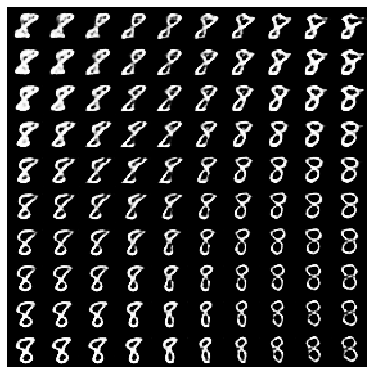

Epoch 161
W estimate: 1.993, grad penlaty: 0.011, gen correction -1.399
W estimate: 1.573, grad penlaty: 0.011, gen correction 0.449
W estimate: 1.066, grad penlaty: 0.013, gen correction 0.137
W estimate: 2.018, grad penlaty: 0.014, gen correction 1.433
W estimate: 1.415, grad penlaty: 0.009, gen correction 0.732
Epoch 162
W estimate: 1.475, grad penlaty: 0.007, gen correction -0.100
W estimate: 1.629, grad penlaty: 0.018, gen correction 1.982
W estimate: 1.461, grad penlaty: 0.014, gen correction 0.359
W estimate: 1.614, grad penlaty: 0.011, gen correction 0.021
W estimate: 1.582, grad penlaty: 0.007, gen correction -1.193
Epoch 163
W estimate: 1.966, grad penlaty: 0.017, gen correction -0.376
W estimate: 1.580, grad penlaty: 0.008, gen correction 0.588
W estimate: 1.638, grad penlaty: 0.010, gen correction -0.489
W estimate: 1.780, grad penlaty: 0.010, gen correction -0.512
W estimate: 1.286, grad penlaty: 0.008, gen correction -0.059
Epoch 164
W estimate: 1.609, grad penlaty: 0.012

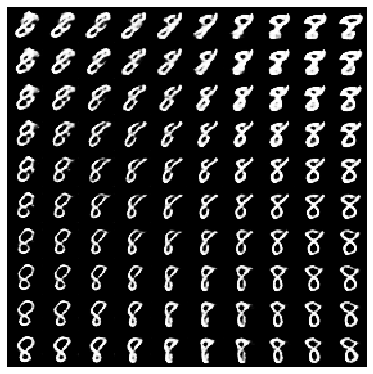

Epoch 171
W estimate: 1.374, grad penlaty: 0.009, gen correction 0.018
W estimate: 1.409, grad penlaty: 0.009, gen correction 0.146
W estimate: 1.234, grad penlaty: 0.014, gen correction -0.502
W estimate: 1.473, grad penlaty: 0.011, gen correction -0.479
W estimate: 1.331, grad penlaty: 0.010, gen correction -0.906
Epoch 172
W estimate: 1.508, grad penlaty: 0.022, gen correction -0.622
W estimate: 0.998, grad penlaty: 0.007, gen correction -0.926
W estimate: 1.616, grad penlaty: 0.008, gen correction -0.462
W estimate: 1.497, grad penlaty: 0.010, gen correction -0.248
W estimate: 1.418, grad penlaty: 0.006, gen correction -0.464
Epoch 173
W estimate: 1.508, grad penlaty: 0.008, gen correction 1.187
W estimate: 1.421, grad penlaty: 0.012, gen correction 0.633
W estimate: 1.698, grad penlaty: 0.013, gen correction 0.611
W estimate: 1.272, grad penlaty: 0.009, gen correction 0.724
W estimate: 1.664, grad penlaty: 0.016, gen correction 0.843
Epoch 174
W estimate: 1.416, grad penlaty: 0.01

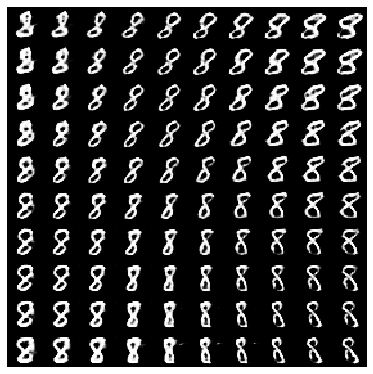

Epoch 181
W estimate: 1.937, grad penlaty: 0.007, gen correction 0.057
W estimate: 1.522, grad penlaty: 0.014, gen correction -0.750
W estimate: 1.247, grad penlaty: 0.009, gen correction -0.627
W estimate: 0.708, grad penlaty: 0.010, gen correction -1.033
W estimate: 1.433, grad penlaty: 0.013, gen correction -1.301
Epoch 182
W estimate: 1.351, grad penlaty: 0.011, gen correction -1.455
W estimate: 2.000, grad penlaty: 0.014, gen correction -0.034
W estimate: 0.846, grad penlaty: 0.007, gen correction -0.997
W estimate: 1.093, grad penlaty: 0.010, gen correction -0.482
W estimate: 1.543, grad penlaty: 0.010, gen correction 0.418
Epoch 183
W estimate: 1.378, grad penlaty: 0.007, gen correction -1.007
W estimate: 1.501, grad penlaty: 0.006, gen correction -1.751
W estimate: 1.620, grad penlaty: 0.009, gen correction -1.210
W estimate: 1.658, grad penlaty: 0.014, gen correction -2.082
W estimate: 1.397, grad penlaty: 0.006, gen correction -1.326
Epoch 184
W estimate: 1.479, grad penlaty:

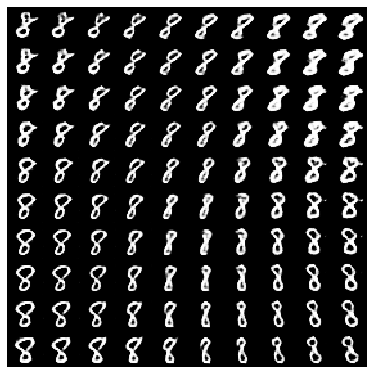

Epoch 191
W estimate: 1.223, grad penlaty: 0.010, gen correction -0.292
W estimate: 2.218, grad penlaty: 0.013, gen correction 0.427
W estimate: 1.426, grad penlaty: 0.008, gen correction 1.616
W estimate: 1.823, grad penlaty: 0.021, gen correction -0.881
W estimate: 1.648, grad penlaty: 0.010, gen correction 1.093
Epoch 192
W estimate: 1.780, grad penlaty: 0.013, gen correction -0.563
W estimate: 1.919, grad penlaty: 0.015, gen correction 0.938
W estimate: 1.842, grad penlaty: 0.015, gen correction -0.337
W estimate: 0.877, grad penlaty: 0.012, gen correction 0.556
W estimate: 1.432, grad penlaty: 0.014, gen correction -0.465
Epoch 193
W estimate: 0.815, grad penlaty: 0.006, gen correction -2.882
W estimate: 1.225, grad penlaty: 0.009, gen correction -0.425
W estimate: 1.367, grad penlaty: 0.012, gen correction 0.296
W estimate: 1.262, grad penlaty: 0.012, gen correction -0.292
W estimate: 1.415, grad penlaty: 0.009, gen correction -0.260
Epoch 194
W estimate: 1.448, grad penlaty: 0.0

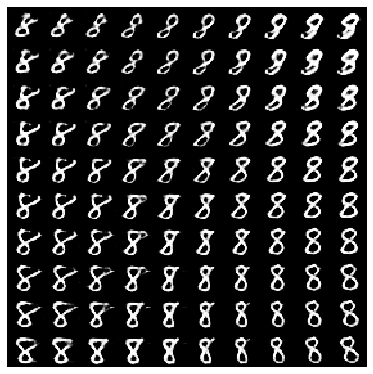

Epoch 201
W estimate: 1.241, grad penlaty: 0.006, gen correction -1.107
W estimate: 1.741, grad penlaty: 0.011, gen correction -2.616
W estimate: 1.518, grad penlaty: 0.007, gen correction -1.121
W estimate: 1.804, grad penlaty: 0.019, gen correction -0.973
W estimate: 1.992, grad penlaty: 0.008, gen correction 0.212
Epoch 202
W estimate: 1.791, grad penlaty: 0.010, gen correction -0.309
W estimate: 1.370, grad penlaty: 0.011, gen correction 1.150
W estimate: 1.224, grad penlaty: 0.010, gen correction -1.665
W estimate: 1.666, grad penlaty: 0.008, gen correction -0.628
W estimate: 1.704, grad penlaty: 0.012, gen correction -1.773
Epoch 203
W estimate: 1.557, grad penlaty: 0.010, gen correction -0.282
W estimate: 1.783, grad penlaty: 0.009, gen correction -0.512
W estimate: 1.153, grad penlaty: 0.006, gen correction -1.206
W estimate: 1.591, grad penlaty: 0.005, gen correction -1.393
W estimate: 1.634, grad penlaty: 0.012, gen correction -0.546
Epoch 204
W estimate: 0.902, grad penlaty:

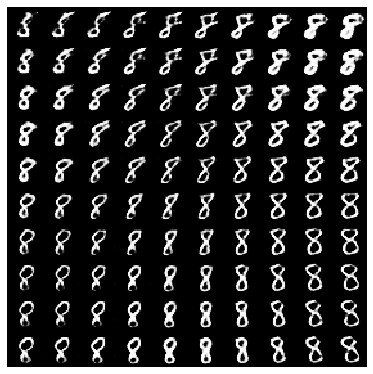

Epoch 211
W estimate: 1.433, grad penlaty: 0.012, gen correction -0.691
W estimate: 0.928, grad penlaty: 0.007, gen correction -0.508
W estimate: 1.278, grad penlaty: 0.010, gen correction -1.181
W estimate: 1.093, grad penlaty: 0.007, gen correction -0.087
W estimate: 1.358, grad penlaty: 0.008, gen correction -0.761
Epoch 212
W estimate: 1.172, grad penlaty: 0.010, gen correction -0.442
W estimate: 1.501, grad penlaty: 0.008, gen correction -1.501
W estimate: 1.617, grad penlaty: 0.013, gen correction -1.279
W estimate: 1.980, grad penlaty: 0.012, gen correction -1.094
W estimate: 1.844, grad penlaty: 0.011, gen correction -1.807
Epoch 213
W estimate: 1.404, grad penlaty: 0.008, gen correction -2.069
W estimate: 1.355, grad penlaty: 0.010, gen correction -1.385
W estimate: 1.741, grad penlaty: 0.013, gen correction -0.349
W estimate: 1.479, grad penlaty: 0.011, gen correction -0.416
W estimate: 1.507, grad penlaty: 0.010, gen correction -0.989
Epoch 214
W estimate: 1.064, grad penlat

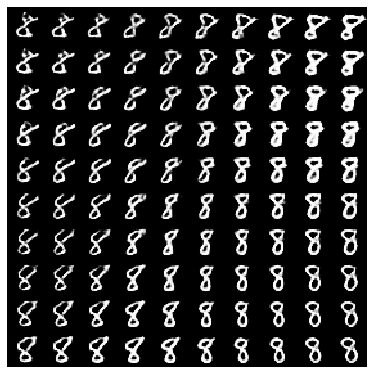

Epoch 221
W estimate: 1.216, grad penlaty: 0.007, gen correction 0.072
W estimate: 1.302, grad penlaty: 0.008, gen correction -1.029
W estimate: 1.486, grad penlaty: 0.013, gen correction -0.620
W estimate: 1.046, grad penlaty: 0.007, gen correction -1.354
W estimate: 1.413, grad penlaty: 0.012, gen correction -0.927
Epoch 222
W estimate: 1.333, grad penlaty: 0.012, gen correction -0.889
W estimate: 1.913, grad penlaty: 0.015, gen correction -1.133
W estimate: 1.236, grad penlaty: 0.012, gen correction -0.996
W estimate: 1.797, grad penlaty: 0.009, gen correction -0.434
W estimate: 1.159, grad penlaty: 0.009, gen correction -0.811
Epoch 223
W estimate: 1.126, grad penlaty: 0.008, gen correction 0.036
W estimate: 1.352, grad penlaty: 0.008, gen correction -1.305
W estimate: 1.874, grad penlaty: 0.010, gen correction -0.651
W estimate: 1.932, grad penlaty: 0.009, gen correction -0.685
W estimate: 1.249, grad penlaty: 0.006, gen correction -3.347
Epoch 224
W estimate: 1.148, grad penlaty:

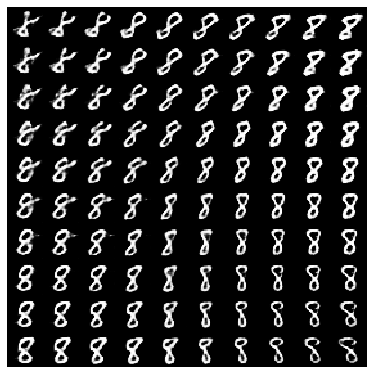

Epoch 231
W estimate: 1.201, grad penlaty: 0.016, gen correction -2.290
W estimate: 0.893, grad penlaty: 0.011, gen correction -1.064
W estimate: 0.964, grad penlaty: 0.012, gen correction -1.641
W estimate: 1.158, grad penlaty: 0.005, gen correction -1.568
W estimate: 1.404, grad penlaty: 0.008, gen correction -2.746
Epoch 232
W estimate: 1.102, grad penlaty: 0.006, gen correction -1.310
W estimate: 1.157, grad penlaty: 0.010, gen correction -1.485
W estimate: 0.834, grad penlaty: 0.009, gen correction -3.441
W estimate: 1.532, grad penlaty: 0.010, gen correction -2.709
W estimate: 1.620, grad penlaty: 0.012, gen correction -1.591
Epoch 233
W estimate: 0.806, grad penlaty: 0.004, gen correction -1.138
W estimate: 1.650, grad penlaty: 0.010, gen correction -2.392
W estimate: 1.323, grad penlaty: 0.006, gen correction -1.023
W estimate: 0.807, grad penlaty: 0.009, gen correction -0.276
W estimate: 1.563, grad penlaty: 0.007, gen correction -0.922
Epoch 234
W estimate: 1.651, grad penlat

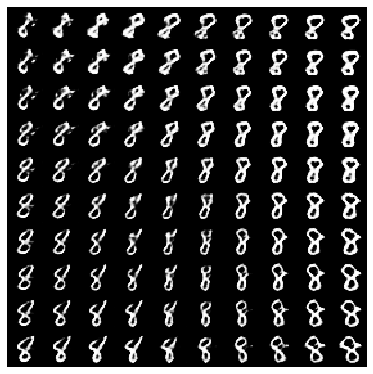

Epoch 241
W estimate: 1.207, grad penlaty: 0.005, gen correction -0.156
W estimate: 1.227, grad penlaty: 0.005, gen correction -0.903
W estimate: 1.199, grad penlaty: 0.008, gen correction -2.640
W estimate: 1.622, grad penlaty: 0.012, gen correction -0.155
W estimate: 1.306, grad penlaty: 0.010, gen correction -0.249
Epoch 242
W estimate: 1.801, grad penlaty: 0.009, gen correction -1.618
W estimate: 1.794, grad penlaty: 0.008, gen correction -0.951
W estimate: 1.380, grad penlaty: 0.017, gen correction -0.281
W estimate: 1.168, grad penlaty: 0.008, gen correction -0.825
W estimate: 1.558, grad penlaty: 0.008, gen correction -2.398
Epoch 243
W estimate: 1.086, grad penlaty: 0.007, gen correction -1.353
W estimate: 1.665, grad penlaty: 0.008, gen correction -1.046
W estimate: 1.802, grad penlaty: 0.010, gen correction -0.597
W estimate: 2.209, grad penlaty: 0.011, gen correction -0.537
W estimate: 1.474, grad penlaty: 0.011, gen correction -1.126
Epoch 244
W estimate: 1.405, grad penlat

In [17]:
for epoch in range(n_epochs):
    print("Epoch", epoch)
    batch_idx = 0
    # iterating over data in dataset
    for data_idx in range(0, datax.shape[0], batch_size):
        data_batch = datax[data_idx:data_idx + batch_size, :, :, np.newaxis]
        labels_batch = labels[data_idx:data_idx + batch_size]
        # discriminator is trained on each epochs
        train_discriminator(data_batch, labels_batch)
        # and generator is trained each n_discr epoch, to ensure convergence of D
        if batch_idx % n_discr == 0:
            w_gen = train_generator(labels_batch)
        # every nth epoch, print summary
        if batch_idx % summary_every_batches == 0:
            for _ in range(discr_extra_steps):
                w_discrim, grad_pen = train_discriminator(data_batch, labels_batch)
            
            print("W estimate: {:.3f}, grad penlaty: {:.3f}, gen correction {:.3f}".format(-w_discrim, 
                                                                                           grad_pen, -w_gen))

        batch_idx += 1
    # visualize
    if epoch % plot_every_epochs == 0:
        grid_images(generator, 8)
        plt.show()
    # shuffle in the end of epoch
    datax, labels = shuffle(datax, labels)

Visualize all classes of images

<Figure size 432x288 with 0 Axes>

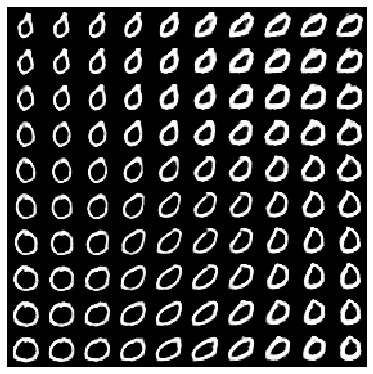

<Figure size 432x288 with 0 Axes>

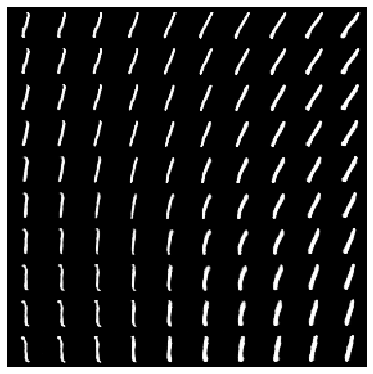

<Figure size 432x288 with 0 Axes>

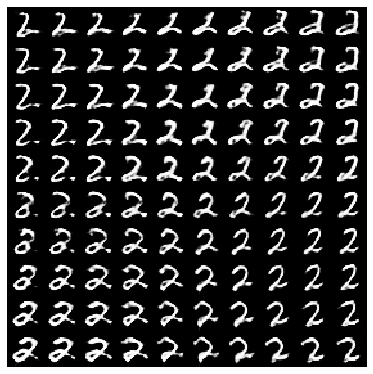

<Figure size 432x288 with 0 Axes>

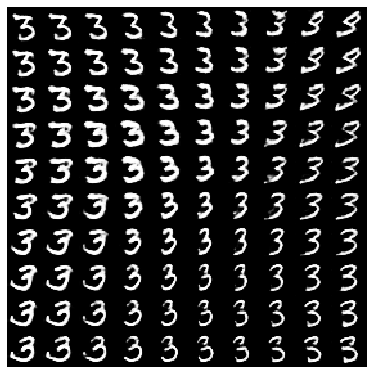

<Figure size 432x288 with 0 Axes>

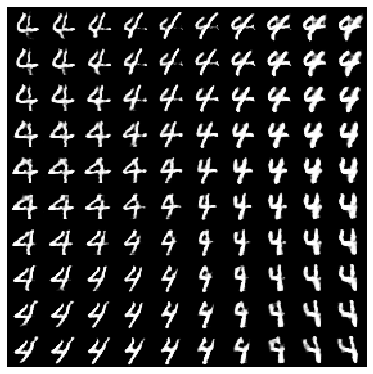

<Figure size 432x288 with 0 Axes>

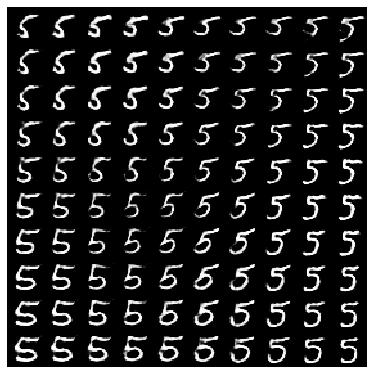

<Figure size 432x288 with 0 Axes>

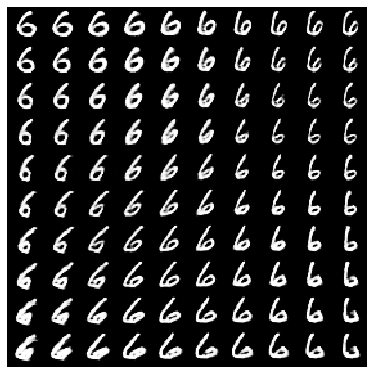

<Figure size 432x288 with 0 Axes>

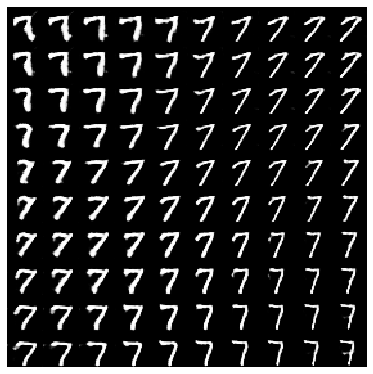

<Figure size 432x288 with 0 Axes>

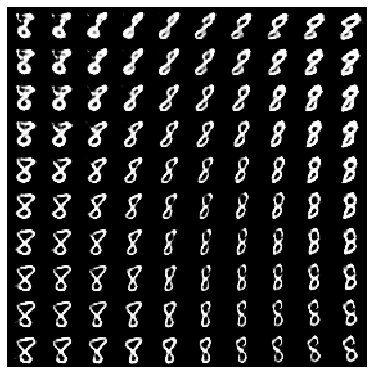

<Figure size 432x288 with 0 Axes>

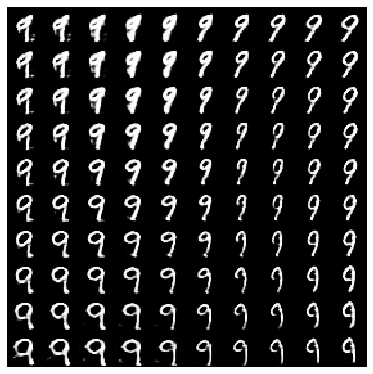

In [18]:
for i in range(n_classes):
    plt.figure()
    grid_images(generator, i)